
# Week 2 : Vector Stores & Retrieval (Colab Workbook)

**Coverage:** 2.1 → 2.9  
- 2.1 Concept Flow: why retrieval is memory  
- 2.2 Geometry of Similarity (cosine vs Euclidean)  
- 2.3 Satyam’s Explanation (intuition)  
- 2.4 Retrieval Backbone (dense + sparse + cache + hybrid ranker)  
- 2.5 Tooling: FAISS vs pgvector vs Weaviate (focus on FAISS here)  
- 2.6 Exercises  
- 2.7 Capstone Milestone (metrics)  
- 2.8 Industry tie-in (recall@k, p95 latency, cost/query)  
- 2.9 Closing Visual: vector retrieval stack

> **Goal**: Build a tiny but *real* retrieval backbone and benchmark it.


## Setup — Install libraries

In [ ]:

!pip -q install sentence-transformers faiss-cpu rank-bm25 numpy matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 36.0 MB/s eta 0:00:00


In [ ]:

import numpy as np, time, math, json, os, textwrap
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
import faiss
from rank_bm25 import BM25Okapi

np.set_printoptions(precision=3, suppress=True)
SEED = 42
rng = np.random.default_rng(SEED)



## 2.1 : Concept Flow: Tiny Semantic Search Demo

**Idea:** Embeddings turn meaning → geometry. We search for *nearby directions* (cosine similarity), not exact words.


In [ ]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Small knowledge base
docs = [
  "Aspirin helps reduce pain and fever.",
  "Possible side effects include stomach irritation and bleeding.",
  "Paracetamol is used for fever in children.",
  "Vitamin C boosts the immune system.",
  "Ibuprofen may cause stomach upset if taken on an empty stomach."
]

model = SentenceTransformer('all-MiniLM-L6-v2')
emb = model.encode(docs, normalize_embeddings=True)
print("Embeddings:", emb.shape)

def dense_search(query, topk=3):
    qv = model.encode(query, normalize_embeddings=True)
    scores = util.cos_sim(qv, emb)[0]
    idx = np.argsort(-scores)[:topk]
    return [(docs[i], float(scores[i])) for i in idx]

query = "Does aspirin upset the stomach?"
for t, s in dense_search(query):
    print(f"{s:.3f} → {t}")


Embeddings: (5, 384)
0.630 → Aspirin helps reduce pain and fever.
0.559 → Ibuprofen may cause stomach upset if taken on an empty stomach.
0.521 → Possible side effects include stomach irritation and bleeding.



## 2.2 : Math/CS Mini: Geometry of Similarity

We compute dot-product, norms, **cosine similarity**, and **Euclidean distance** for two vectors.


In [ ]:
a = np.array([1,2,0,3], dtype=float)
b = np.array([2,1,0,2], dtype=float)

dot = float(np.dot(a,b))
na, nb = np.linalg.norm(a), np.linalg.norm(b)
cosine = dot/(na*nb)
dist = float(np.linalg.norm(a-b))

print(f"dot(a,b) = {dot:.2f}")
print(f"|a|={na:.2f}  |b|={nb:.2f}")
print(f"cosine(a,b) = {cosine:.3f}")
print(f"euclidean(a,b) = {dist:.3f}")

# Scaling invariance of cosine
cosine_scaled = float(np.dot(2*a,b)/(np.linalg.norm(2*a)*np.linalg.norm(b)))
print("cosine(2a,b) =", round(cosine_scaled,3))


dot(a,b) = 10.00
|a|=3.74  |b|=3.00
cosine(a,b) = 0.891
euclidean(a,b) = 1.732
cosine(2a,b) = 0.891


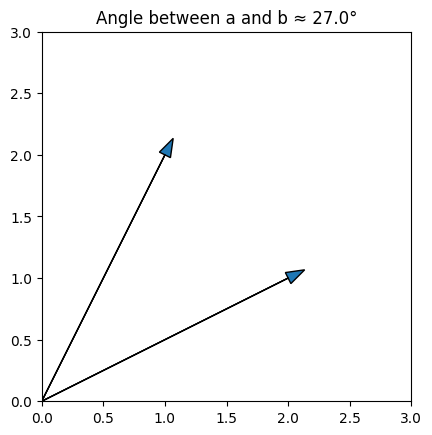

In [ ]:
import math
import matplotlib.pyplot as plt

# Visualize angle in 2D (using first two dims)
ang = math.degrees(math.acos(cosine))
fig, ax = plt.subplots()
ax.arrow(0,0,a[0],a[1], head_width=0.1)
ax.arrow(0,0,b[0],b[1], head_width=0.1)
ax.set_aspect('equal'); ax.set_xlim(0,3); ax.set_ylim(0,3)
ax.set_title(f"Angle between a and b ≈ {ang:.1f}°")
plt.show()



### Bonus: Volume collapse : the curse of dimensionality


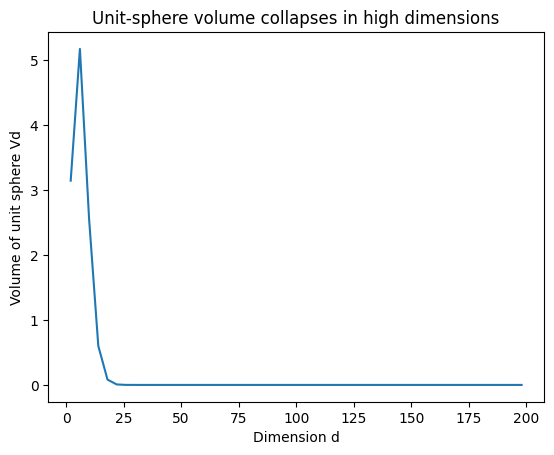

In [ ]:
dims = np.arange(2, 201, 4)
vol = (np.pi**(dims/2)) / np.array([math.gamma(d/2 + 1) for d in dims])
plt.plot(dims, vol)
plt.xlabel("Dimension d"); plt.ylabel("Volume of unit sphere Vd")
plt.title("Unit-sphere volume collapses in high dimensions")
plt.show()



## 2.4 : Retrieval Backbone: Dense + Sparse + Cache + Hybrid Ranker

We combine dense (semantic) with sparse (keyword BM25), plus a tiny in-memory cache.


In [ ]:
from rank_bm25 import BM25Okapi
import numpy as np

# Prepare BM25 corpus
bm25 = BM25Okapi([d.lower().split() for d in docs])

def sparse_search(query, topk=3):
    scores = bm25.get_scores(query.lower().split())
    idx = np.argsort(-scores)[:topk]
    return [(docs[i], float(scores[i])) for i in idx]

def show(title, pairs):
    print("\n"+title);
    for t,s in pairs: print(f"{s:.3f} → {t}")

show("Dense only", dense_search("stomach pain"))
show("Sparse only", sparse_search("stomach pain"))



Dense only
0.467 → Ibuprofen may cause stomach upset if taken on an empty stomach.
0.444 → Possible side effects include stomach irritation and bleeding.
0.202 → Paracetamol is used for fever in children.

Sparse only
1.214 → Aspirin helps reduce pain and fever.
0.329 → Possible side effects include stomach irritation and bleeding.
0.280 → Ibuprofen may cause stomach upset if taken on an empty stomach.


In [ ]:
# Hybrid ranker with linear blending
alpha = 0.6  # semantic weight

def hybrid_search(query, topk=3):
    d_hits = {t:s for t,s in dense_search(query, topk=5)}
    s_hits = {t:s for t,s in sparse_search(query, topk=5)}
    all_docs = set(d_hits)|set(s_hits)
    merged = [(d, alpha*d_hits.get(d,0)+(1-alpha)*s_hits.get(d,0)) for d in all_docs]
    return sorted(merged, key=lambda x:-x[1])[:topk]

show("Hybrid", hybrid_search("stomach pain"))



Hybrid
0.591 → Aspirin helps reduce pain and fever.
0.398 → Possible side effects include stomach irritation and bleeding.
0.392 → Ibuprofen may cause stomach upset if taken on an empty stomach.


In [ ]:
from collections import OrderedDict
import time

# Tiny LRU cache for repeated queries
from collections import OrderedDict
class LRUCache:
    def __init__(self, cap=3): self.cap=cap; self.d=OrderedDict()
    def get(self,k):
        if k not in self.d: return None
        self.d.move_to_end(k); return self.d[k]
    def put(self,k,v):
        if k in self.d: self.d.move_to_end(k)
        elif len(self.d)>=self.cap: self.d.popitem(last=False)
        self.d[k]=v

cache = LRUCache(cap=3)

def query_with_cache(q):
    res = cache.get(q)
    if res is not None: return res, True
    res = hybrid_search(q)
    cache.put(q, res); return res, False

for q in ["stomach pain","child medicine","vitamin for health","stomach pain"]:
    t=time.time(); res,hit = query_with_cache(q); dt=1000*(time.time()-t)
    print(("cache" if hit else "new"), f"{q:20s} → {dt:6.1f} ms → {[r[0] for r in res]}")


new stomach pain         →   17.2 ms → ['Aspirin helps reduce pain and fever.', 'Possible side effects include stomach irritation and bleeding.', 'Ibuprofen may cause stomach upset if taken on an empty stomach.']
new child medicine       →   14.7 ms → ['Paracetamol is used for fever in children.', 'Aspirin helps reduce pain and fever.', 'Vitamin C boosts the immune system.']
new vitamin for health   →   14.6 ms → ['Vitamin C boosts the immune system.', 'Paracetamol is used for fever in children.', 'Aspirin helps reduce pain and fever.']
cache stomach pain         →    0.0 ms → ['Aspirin helps reduce pain and fever.', 'Possible side effects include stomach irritation and bleeding.', 'Ibuprofen may cause stomach upset if taken on an empty stomach.']



## 2.5 : FAISS Index: speed demo

We build a larger synthetic corpus, index with FAISS, and measure query latency.


In [ ]:
import faiss
import numpy as np
import time
from sentence_transformers import SentenceTransformer

# Synthetic corpus (1k docs)
big_docs = [f"Doc {i} about AI, ML, topic {i}" for i in range(1000)]
big_emb = model.encode(big_docs, normalize_embeddings=True).astype('float32')
dim = big_emb.shape[1]
index = faiss.IndexFlatIP(dim)  # inner product = cosine for normalized vectors
index.add(big_emb)
print("Vector count:", index.ntotal)

q = "deep learning"
qv = model.encode([q], normalize_embeddings=True).astype('float32')
t=time.time(); D,I = index.search(qv, 5); ms = 1000*(time.time()-t)
print(f"Top-5 in {ms:.2f} ms")
for rank,(i,d) in enumerate(zip(I[0], D[0]),1):
    print(rank, f"{d:.4f} → {big_docs[i]}")


Vector count: 1000
Top-5 in 0.52 ms
1 0.4043 → Doc 111 about AI, ML, topic 111
2 0.4030 → Doc 900 about AI, ML, topic 900
3 0.4019 → Doc 119 about AI, ML, topic 119
4 0.4004 → Doc 9 about AI, ML, topic 9
5 0.3925 → Doc 281 about AI, ML, topic 281


## 2.6 : Exercises

1. **Cosine Playground:** Generate two 300-D random vectors and compute cosine similarity manually, then compare to FAISS dot-product.
2. **Index Benchmark:** Measure FAISS search latency for 1k vs 5k docs.
3. **Cache Policy:** Modify cache capacity and see cache-hit vs latency.
4. **Math:** Verify numerically that for normalized vectors, `d^2 = 2(1-cos)`.


In [ ]:
# 1) Cosine Playground
import numpy as np

# Create a reproducible random number generator
rng = np.random.default_rng(seed=42)

# Generate two random 300-dimensional vectors
a, b = rng.standard_normal(300), rng.standard_normal(300)

# Compute cosine similarity manually
cos = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
print("Cosine similarity (manual):", cos)


Cosine similarity (manual): 0.03301918616068954


In [ ]:
# 2) Index Benchmark (1k vs 5k)
def build_index(n):
    texts = [f"Doc {i} about topic {i}" for i in range(n)]
    e = model.encode(texts, normalize_embeddings=True).astype('float32')
    ix = faiss.IndexFlatIP(e.shape[1]); ix.add(e); return ix, texts
for n in [1000, 5000]:
    ix, texts = build_index(n)
    qv = model.encode(["neural networks"], normalize_embeddings=True).astype('float32')
    t=time.time(); ix.search(qv, 5); ms=1000*(time.time()-t)
    print(f"n={n:5d} → {ms:6.2f} ms")


n= 1000 →   0.33 ms
n= 5000 →   0.97 ms


In [ ]:
# Math equivalence check
u = rng.standard_normal(128); v = rng.standard_normal(128)
u/=np.linalg.norm(u); v/=np.linalg.norm(v)   # normalize
cos = np.dot(u,v)
d2 = np.sum((u-v)**2)
print("cos =", round(cos,6), "  d^2 =", round(d2,6), "  2(1-cos) =", round(2*(1-cos),6))


cos = 0.170183   d^2 = 1.659634   2(1-cos) = 1.659634



## 2.7 : Capstone Milestone: Metrics

We compute **Avg latency** and **Cache hit %** over a query set.


In [ ]:
queries = ["stomach pain","child medicine","vitamin for health","stomach pain","child medicine"]
times=[]; hits=0
for q in queries:
    t=time.time(); _,hit = query_with_cache(q); times.append(1000*(time.time()-t))
    hits += int(hit)
print("Avg latency (ms/query):", round(np.mean(times),2))
print("Cache hit ratio (%):", round(100*hits/len(queries),1))


Avg latency (ms/query): 0.0
Cache hit ratio (%): 100.0


## 2.8 : Industry Metrics to Monitor

- **Recall@k**: fraction of relevant docs among the top-k results (target ≥ 0.85 on semantic corpora).  
- **Latency p95**: 95th percentile query time (target ≤ 100 ms for consumer apps; ≤ 300 ms for enterprise).  
- **Cost per Query**: embedding lookup + cache + ANN search + LLM tokens.

> In practice, you log these with Prometheus/Grafana or Datadog and alert when drift occurs.


## 2.9 : Closing Visual: The Vector Retrieval Stack

```
LLM / Application Layer
↑
Retriever Layer  (Hybrid Ranker)
↑
Vector Store      (FAISS / pgvector / Weaviate)
↑
Cache Layer       (Redis / Memcached)
↑
Storage Layer     (Raw Docs / DB / Logs)
```
**Mnemonic:** storage → cache → semantic index → ranking → reasoning.
